# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load and Explore the Dataset

In [ ]:
data = pd.read_csv("youtube_channel_data.csv")

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 70 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  364 non-null    int64  
 1   Video Duration                      364 non-null    float64
 2   Video Publish Time                  364 non-null    object 
 3   Days Since Publish                  364 non-null    int64  
 4   Day                                 364 non-null    int64  
 5   Month                               364 non-null    int64  
 6   Year                                364 non-null    int64  
 7   Day of Week                         364 non-null    object 
 8   Revenue per 1000 Views (USD)        364 non-null    float64
 9   Monetized Playbacks (Estimate)      364 non-null    float64
 10  Playback-Based CPM (USD)            364 non-null    float64
 11  CPM (USD)                           364 non-n

In [ ]:
print(data.isnull().sum())

ID                         0
Video Duration             0
Video Publish Time         0
Days Since Publish         0
Day                        0
                          ..
Watch Time (hours)         0
Subscribers                0
Estimated Revenue (USD)    0
Impressions                0
Video Thumbnail CTR (%)    0
Length: 70, dtype: int64


In [ ]:
data.head()

,ID,Video Duration,Video Publish Time,Days Since Publish,Day,Month,Year,Day of Week,Revenue per 1000 Views (USD),Monetized Playbacks (Estimate),...,Watched (Not Skipped) (%),Feed Impressions,Average View Percentage (%),Average View Duration,Views,Watch Time (hours),Subscribers,Estimated Revenue (USD),Impressions,Video Thumbnail CTR (%)
0,0,201.0,2016-06-02 00:00:00,0,2,6,2016,Thursday,0.024,723.0,...,0.0,0.0,40.38,81.0,23531.0,533.1636,51.0,0.561,41118.0,27.66
1,1,391.0,2016-06-10 00:00:00,8,10,6,2016,Friday,0.056,727.0,...,0.0,0.0,39.85,156.0,11478.0,500.5628,33.0,0.648,41627.0,5.85
2,2,133.0,2016-06-14 00:00:00,4,14,6,2016,Tuesday,0.014,76.0,...,0.0,0.0,30.88,41.0,6153.0,70.7287,8.0,0.089,38713.0,7.07
3,3,14.0,2016-06-29 00:00:00,15,29,6,2016,Wednesday,0.004,18.0,...,0.0,0.0,103.05,14.0,4398.0,17.6251,2.0,0.017,35245.0,5.60
4,4,45.0,2016-07-01 00:00:00,2,1,7,2016,Friday,0.000,0.0,...,0.0,0.0,55.70,25.0,14659.0,104.3341,28.0,0.000,46218.0,8.62


# Data Cleaning

Handle Missing Values

In [ ]:
# Fill or drop null values
data = data.dropna()

Convert Duration

In [ ]:
# Convert 'Video Duration' into seconds
!pip install isodate

In [ ]:
import pandas as pd
import isodate
data = pd.DataFrame({'Video Duration': ['PT1H2M30S', 'PT45M', 'PT30S', None]})

data['Video Duration'] = data['Video Duration'].dropna().apply(
    lambda x: isodate.parse_duration(x).total_seconds() if pd.notna(x) else None
)

In [ ]:
def safe_parse_duration(x):
    try:
      return isodate.parse_duration(str(x)).total_seconds()
    except Exception:
        try:
            return float(x)
        except:
            return None

data['Video Duration'] = data['Video Duration'].astype(str).apply(safe_parse_duration)


In [ ]:
# Reload the dataset
data = pd.read_csv("youtube_channel_data.csv")

# Convert 'Video Publish Time' to datetime objects
data['Video Publish Time'] = pd.to_datetime(data['Video Publish Time'])

# Exploratory Data Analysis (EDA)

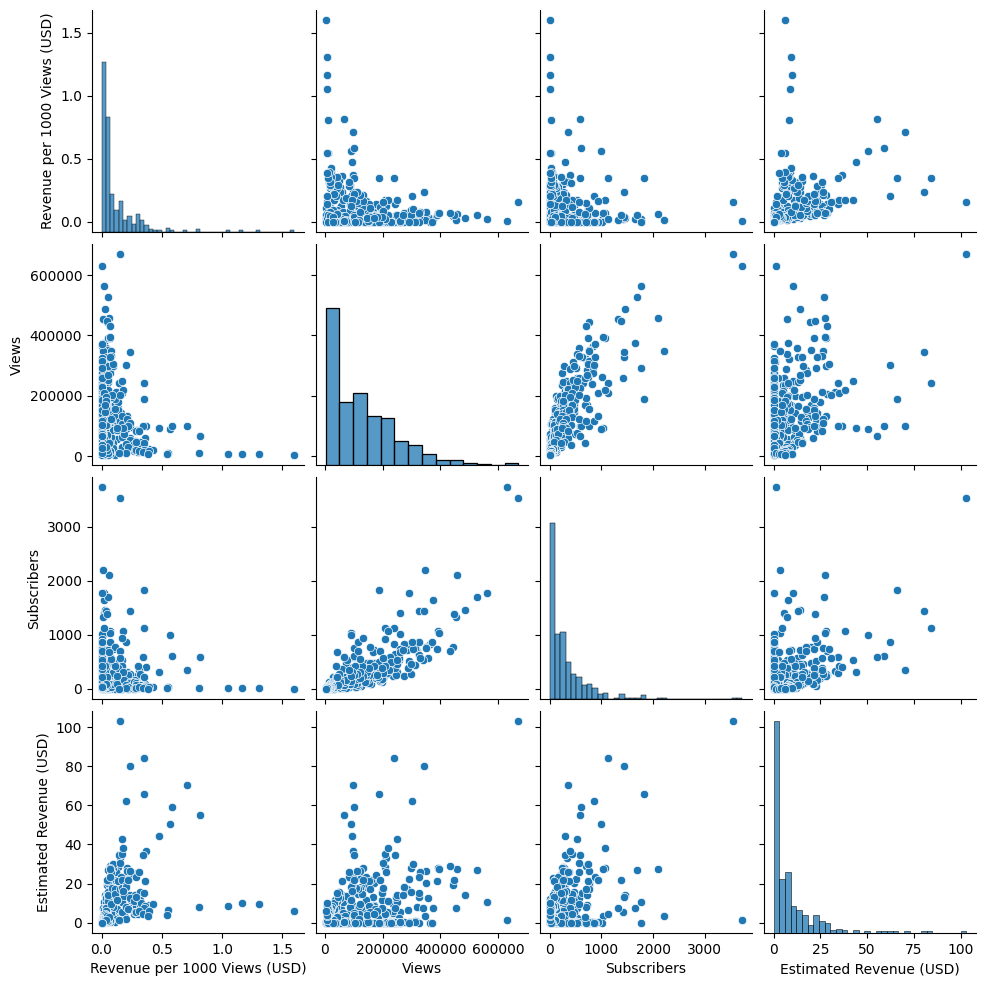

In [ ]:
# Pairplot to visualize relationships
sns.pairplot(data[['Revenue per 1000 Views (USD)', 'Views',
'Subscribers', 'Estimated Revenue (USD)']])
plt.show()

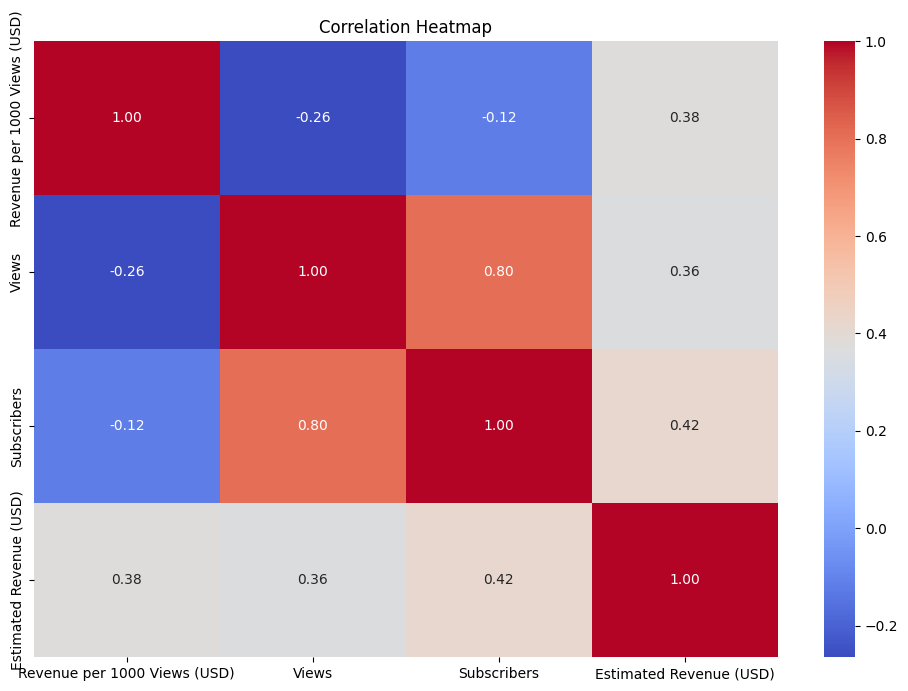

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(data[['Revenue per 1000 Views (USD)', 'Views',
                  'Subscribers', 'Estimated Revenue (USD)']].corr(),
            annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
top_videos = data.sort_values(by='Estimated Revenue (USD)', ascending=False).head(10)
display(top_videos[['ID', 'Estimated Revenue (USD)', 'Views', 'Subscribers']])

,ID,Estimated Revenue (USD),Views,Subscribers
228,228,103.117,670990.0,3538.0
257,257,83.979,241060.0,1125.0
251,251,80.265,343319.0,1437.0
289,289,70.247,99196.0,350.0
278,278,65.978,188324.0,1824.0
260,260,62.047,302999.0,866.0
293,293,59.058,101025.0,602.0
294,294,55.040,67556.0,581.0
290,290,50.344,89284.0,995.0
284,284,44.228,93487.0,305.0


# Feature Engineering

In [ ]:
import numpy as np

# Avoid division by zero
data['Revenue per View'] = np.where(data['Views'] > 0, data['Estimated Revenue (USD)'] / data['Views'], 0)

# Check if 'Comments' column exists, if not, create it with 0 values
if 'Comments' not in data.columns:
    data['Comments'] = 0  # Or any other appropriate default value

# Now calculate Engagement Rate
data['Engagement Rate'] = np.where(data['Views'] > 0,
                                   (data['Likes'] + data['Shares'] + data['Comments']) / data['Views'] * 100, 0)


# Data Visualization

## Revenue Distribution

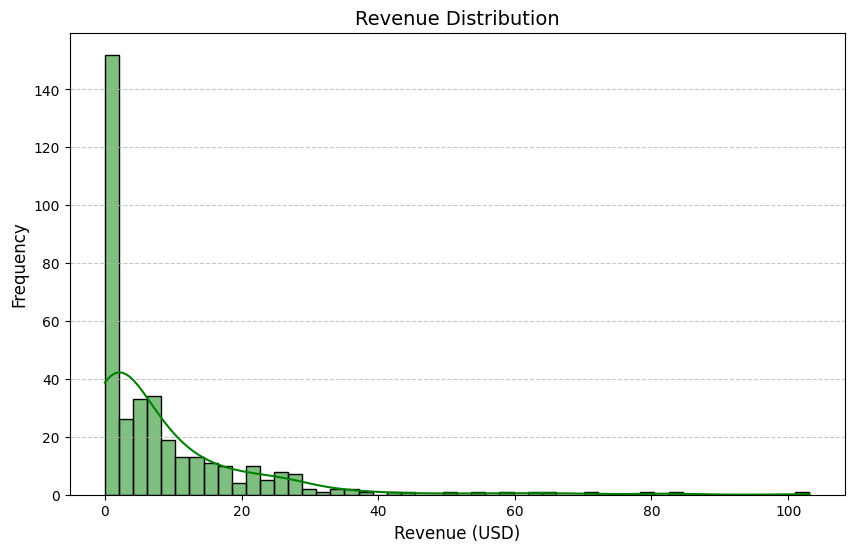

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data['Estimated Revenue (USD)'], bins=50, kde=True, color='green')
plt.title("Revenue Distribution", fontsize=14)
plt.xlabel("Revenue (USD)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Revenue vs Views:

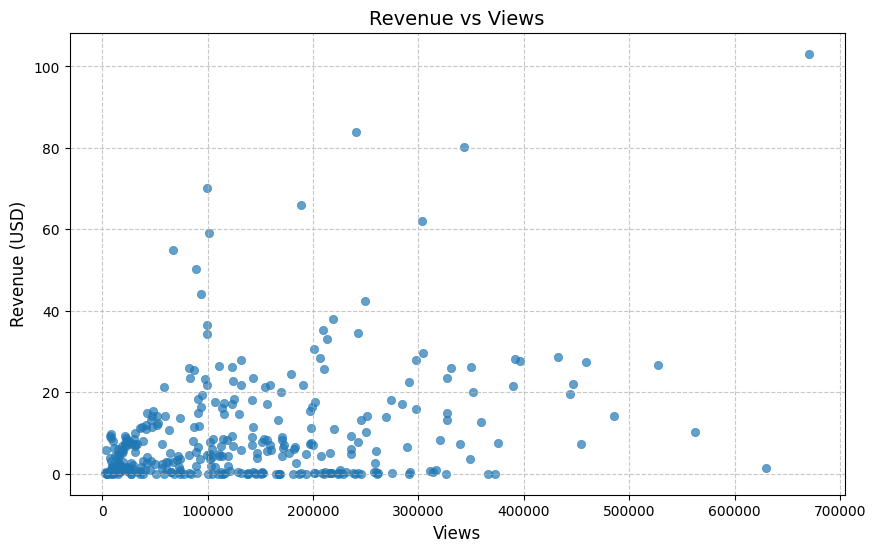

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Views'], y=data['Estimated Revenue (USD)'], alpha=0.7, edgecolor=None)
plt.title("Revenue vs Views", fontsize=14)
plt.xlabel("Views", fontsize=12)
plt.ylabel("Revenue (USD)", fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.show()

# Predictive Model: Estimate Revenue

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Select features and target
features = ['Views', 'Subscribers', 'Likes', 'Shares', 'Comments', 'Engagement Rate']
target = 'Estimated Revenue (USD)'

X = data[features]
y = data[target]

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

In [ ]:
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

Mean Squared Error: 90.99
R-squared Score: -0.05


# Insights and Recommendations

/tmp/ipython-input-45376067.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


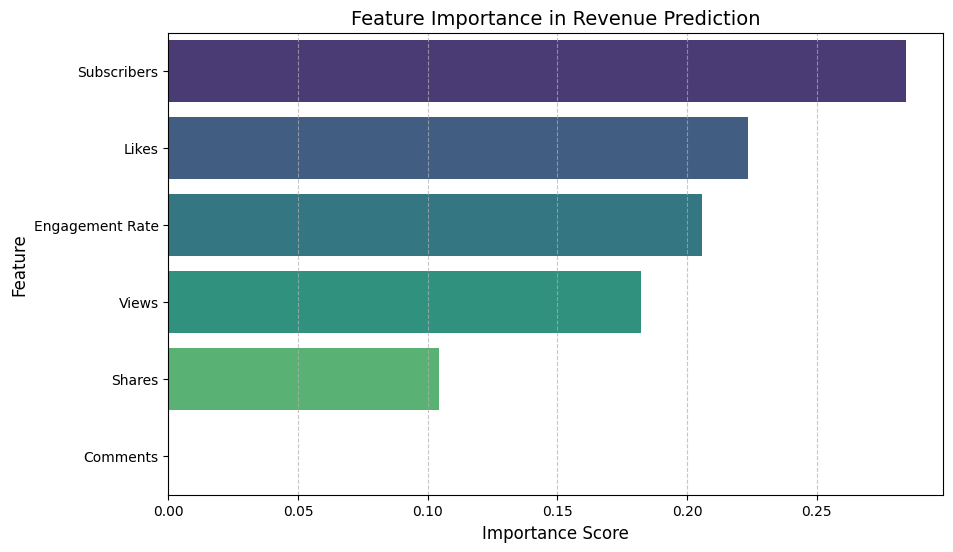

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Feature Importance in Revenue Prediction", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Deployment and Presentation

In [ ]:
import joblib

# Save trained model
joblib.dump(model, 'youtube_revenue_predictor.pkl')

# To load the model later
loaded_model = joblib.load('youtube_revenue_predictor.pkl')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the dataset
df = pd.read_csv('/content/youtube_channel_data.csv')
df.head()

,ID,Video Duration,Video Publish Time,Days Since Publish,Day,Month,Year,Day of Week,Revenue per 1000 Views (USD),Monetized Playbacks (Estimate),...,Watched (Not Skipped) (%),Feed Impressions,Average View Percentage (%),Average View Duration,Views,Watch Time (hours),Subscribers,Estimated Revenue (USD),Impressions,Video Thumbnail CTR (%)
0,0,201.0,2016-06-02 00:00:00,0,2,6,2016,Thursday,0.024,723.0,...,0.0,0.0,40.38,81.0,23531.0,533.1636,51.0,0.561,41118.0,27.66
1,1,391.0,2016-06-10 00:00:00,8,10,6,2016,Friday,0.056,727.0,...,0.0,0.0,39.85,156.0,11478.0,500.5628,33.0,0.648,41627.0,5.85
2,2,133.0,2016-06-14 00:00:00,4,14,6,2016,Tuesday,0.014,76.0,...,0.0,0.0,30.88,41.0,6153.0,70.7287,8.0,0.089,38713.0,7.07
3,3,14.0,2016-06-29 00:00:00,15,29,6,2016,Wednesday,0.004,18.0,...,0.0,0.0,103.05,14.0,4398.0,17.6251,2.0,0.017,35245.0,5.60
4,4,45.0,2016-07-01 00:00:00,2,1,7,2016,Friday,0.000,0.0,...,0.0,0.0,55.70,25.0,14659.0,104.3341,28.0,0.000,46218.0,8.62


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 70 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  364 non-null    int64  
 1   Video Duration                      364 non-null    float64
 2   Video Publish Time                  364 non-null    object 
 3   Days Since Publish                  364 non-null    int64  
 4   Day                                 364 non-null    int64  
 5   Month                               364 non-null    int64  
 6   Year                                364 non-null    int64  
 7   Day of Week                         364 non-null    object 
 8   Revenue per 1000 Views (USD)        364 non-null    float64
 9   Monetized Playbacks (Estimate)      364 non-null    float64
 10  Playback-Based CPM (USD)            364 non-null    float64
 11  CPM (USD)                           364 non-n

In [ ]:
df.isnull().sum()

,0
ID,0
Video Duration,0
Video Publish Time,0
Days Since Publish,0
Day,0
...,...
Watch Time (hours),0
Subscribers,0
Estimated Revenue (USD),0
Impressions,0


In [ ]:
# Convert 'Video Publish Time' to datetime format
df['Video Publish Time'] = pd.to_datetime(df['Video Publish Time'])

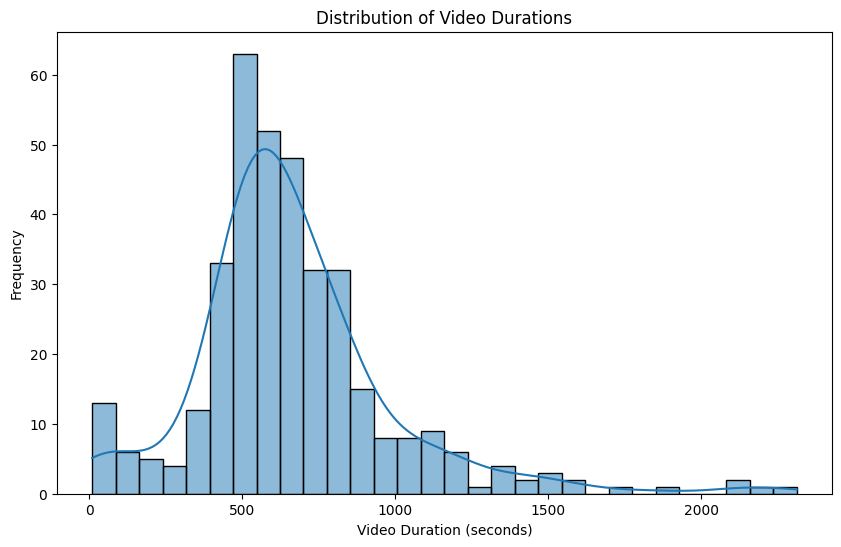

In [ ]:
# Distribution of video durations
plt.figure(figsize=(10, 6))
sns.histplot(df['Video Duration'], bins=30, kde=True)
plt.title('Distribution of Video Durations')
plt.xlabel('Video Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

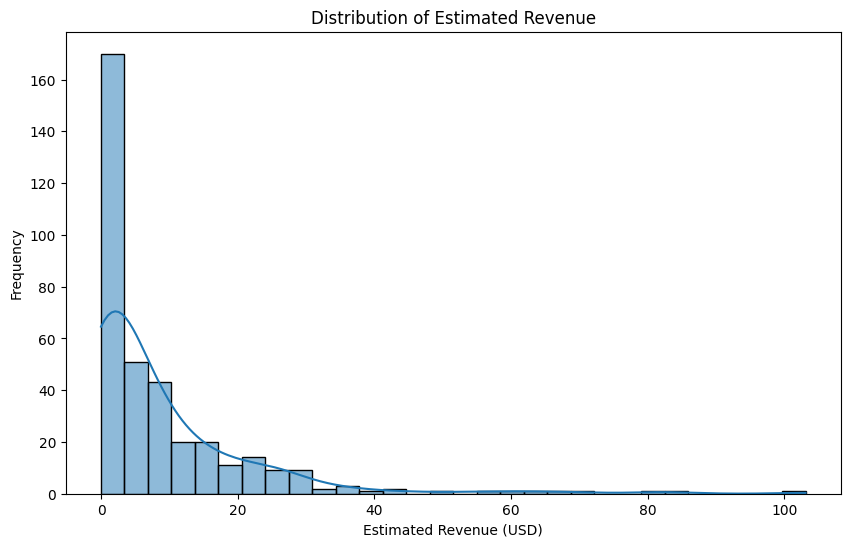

In [ ]:
# Revenue distribution

plt.figure(figsize=(10, 6))
sns.histplot(df['Estimated Revenue (USD)'], bins=30, kde=True)
plt.title('Distribution of Estimated Revenue')
plt.xlabel('Estimated Revenue (USD)')
plt.ylabel('Frequency')
plt.show()

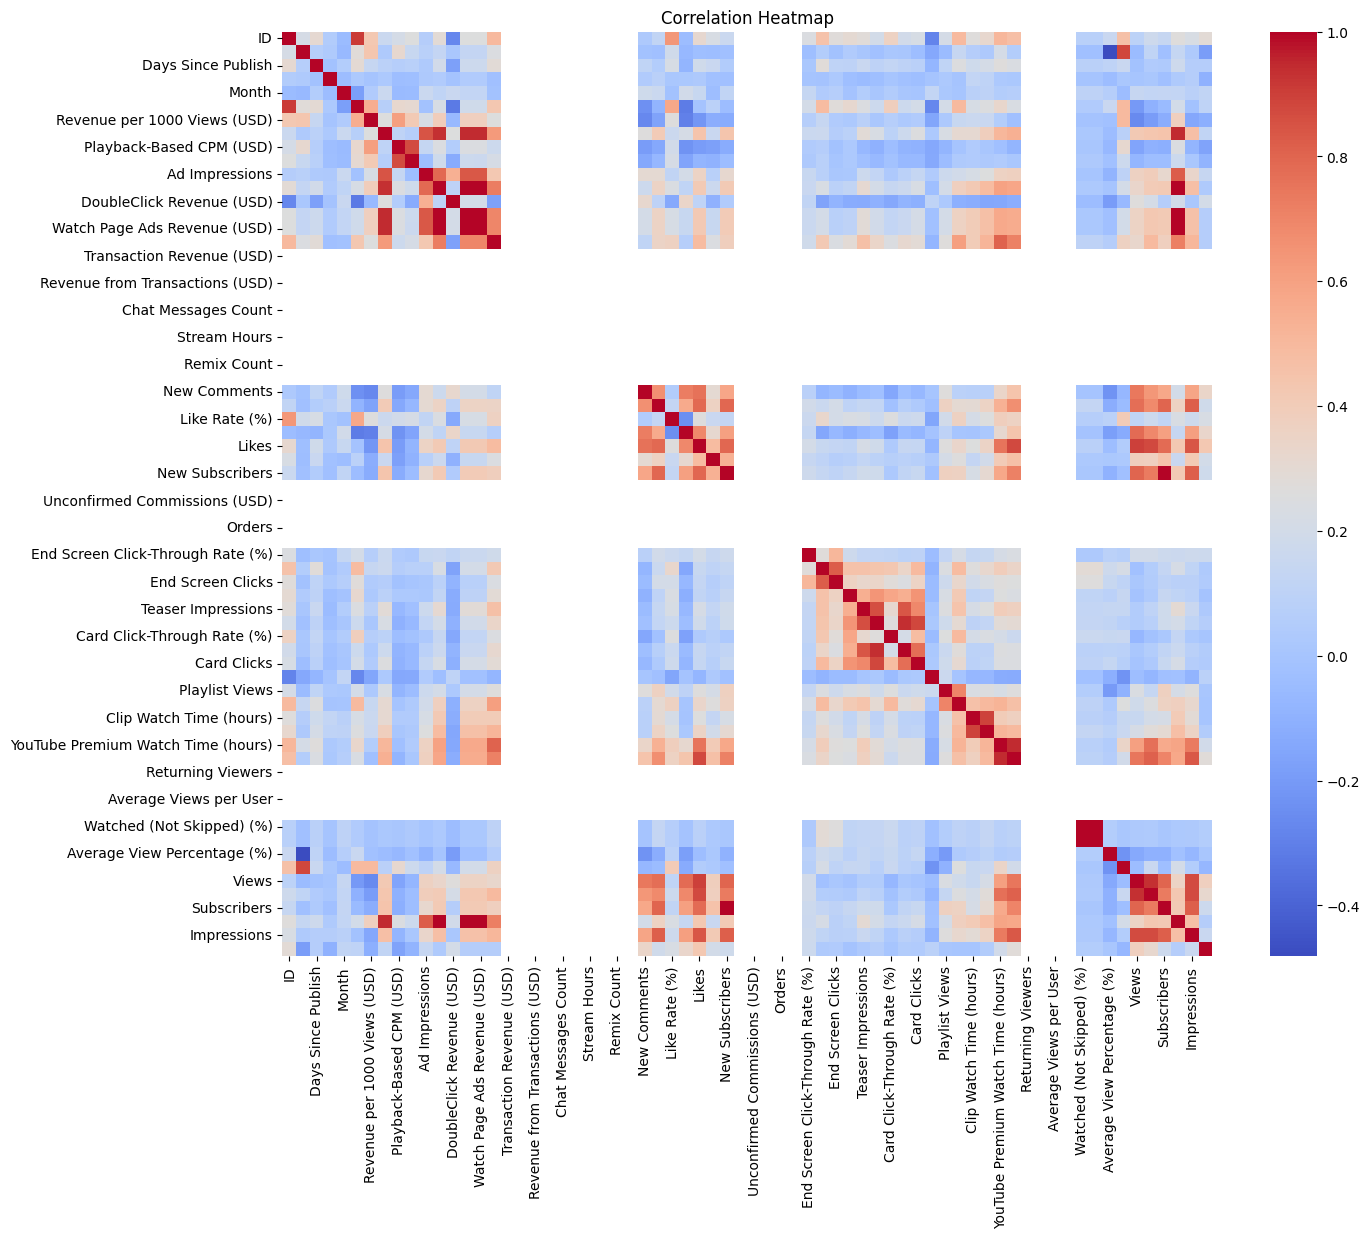

In [ ]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

# Define features and target variable
X = numeric_df.drop(columns=['Estimated Revenue (USD)'])
y = numeric_df['Estimated Revenue (USD)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100,
random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the prediction accuracy
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse


np.float64(0.45593992214488205)

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

ValueError: could not convert string to float: 'Thursday'

<Figure size 1200x800 with 0 Axes>